In [1]:
# Import packages to use
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'errorbar.capsize': 2})

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Define the file to explore
file='resumen_N100_Niter25000000_beta4.0_dt4e-06_lf1.0_stf50_Nsimstot1000_mul10.csv'

# Define the parameters for the simulation
N=100
beta=4.0
s=1.0
nu=-1/(beta+1)

# Import the data file
df=pd.read_csv(file, engine='python')
print(df.columns.tolist())
print('Theoretical exponent (nu)= %g'%nu)

['t', 'log_t', 'N_avg', 'std_N', 'log_N']
Theoretical exponent (nu)= -0.2


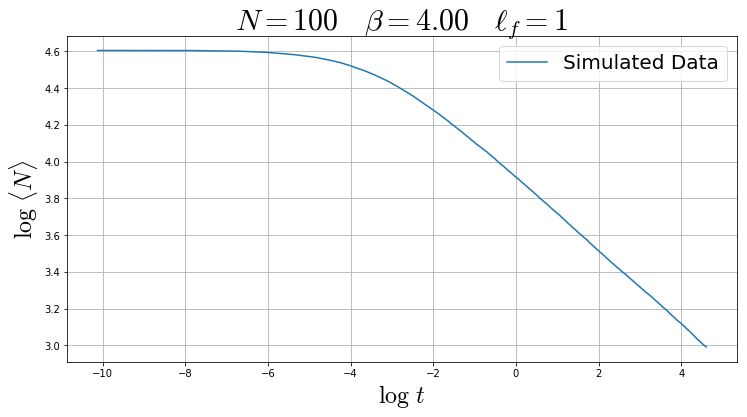

In [4]:
# Plot the entire log-data 
plt.figure(figsize=(12,6))

plt.plot(df.log_t,df.log_N, label='Simulated Data')

plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()

In [5]:
# Cut the data in order to analyze the last part
# The cut-value can be changed and will change the results
cut=-1
cut2=2.5
df_tail=df[(df['log_t']>cut) & (df['log_t']<cut2)]

# LINEAR REGRESSION FOR MEAN VALUE

In [6]:
# Perform the linear regression for the asymptotic behaviour of the mean values
X=df_tail['log_t']
y=df_tail['log_N']

X = sm.add_constant(X)
model=sm.OLS(y,X)
results=model.fit()
nu_res=results.params[1]

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_N   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.333e+09
Date:                Wed, 19 Jun 2019   Prob (F-statistic):               0.00
Time:                        09:40:07   Log-Likelihood:             1.4544e+06
No. Observations:              295366   AIC:                        -2.909e+06
Df Residuals:                  295364   BIC:                        -2.909e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9170   7.43e-06   5.27e+05      0.0

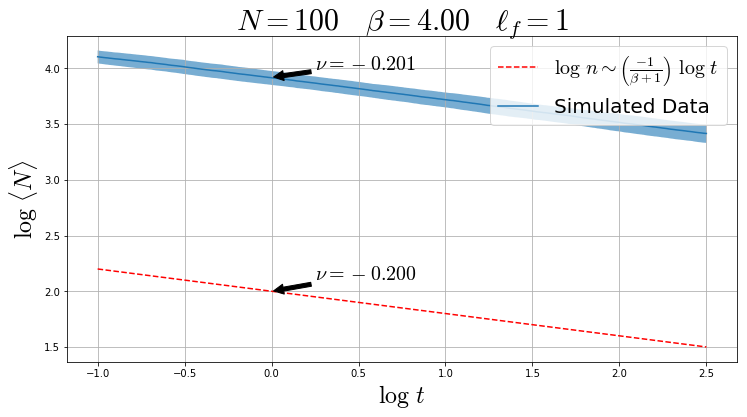

In [14]:
# Plot the partial data with the theoretical behaviour 
plt.figure(figsize=(12,6))

# Define the data for the theoretical behaviour comparison
xreg=np.linspace(min(df_tail.log_t),max(df_tail.log_t))
yreg=-(1.0/(beta+1.0))*xreg+2
plt.annotate(r'$\nu=%.3f$'%nu, 
             xy=(0.0, 2.),
             xytext=(0.25,2.1),
             xycoords='data',
             arrowprops=dict(arrowstyle="simple",facecolor='black'),
             fontsize=20)

ecu=r'$\log \ n \sim  \left( \frac{-1}{\beta+1} \right) \ \log \ t$'
plt.plot(xreg,yreg,'--',c='red',label=ecu)

plt.plot(df_tail.log_t,df_tail.log_N,label='Simulated Data')

upper=np.log(df_tail['N_avg']+df_tail['std_N'])
lower=np.log(df_tail['N_avg']-df_tail['std_N'])
plt.fill_between(df_tail.log_t,upper,lower,alpha=0.6)
plt.annotate(r'$\nu=%.3f$'%nu_res, 
             xy=(0., 3.92),
             xytext=(0.25,3.99),
             xycoords='data',
             arrowprops=dict(arrowstyle="simple",facecolor='black'),
             fontsize=20)


plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.grid(zorder=3)
plt.legend(fontsize=20,loc=1)
plt.show()
plt.close()

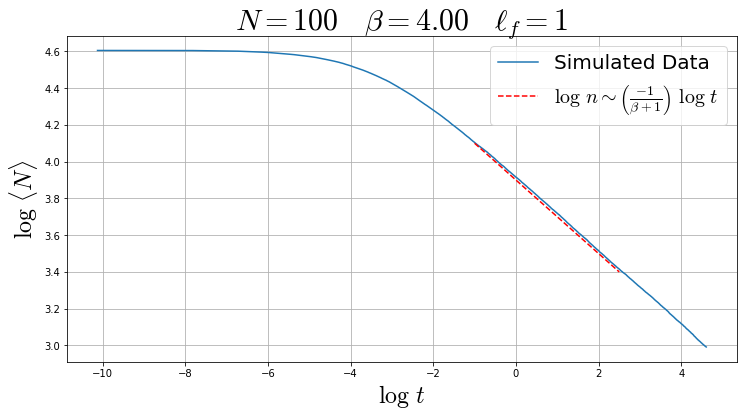

In [22]:
plt.figure(figsize=(12,6))

xreg=np.linspace(min(df_tail.log_t),max(df_tail.log_t))
yreg=-(1.0/(beta+1.0))*xreg+3.9

plt.plot(df.log_t,df.log_N,label='Simulated Data')

ecu=r'$\log \ n \sim  \left( \frac{-1}{\beta+1} \right) \ \log \ t$'
plt.plot(xreg,yreg,'--',c='red',label=ecu)

plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()

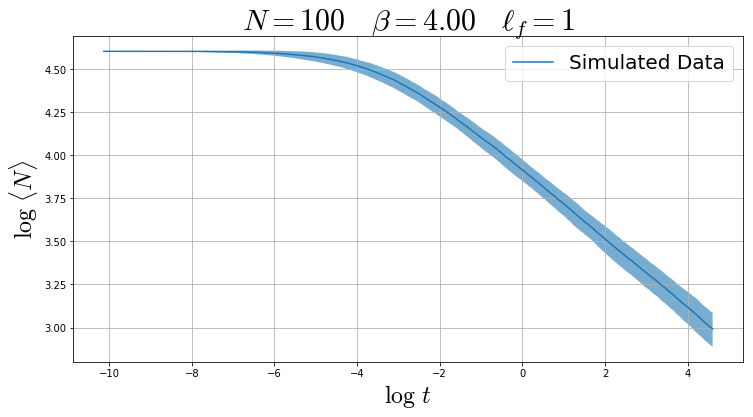

In [9]:
plt.figure(figsize=(12,6))

plt.plot(df.log_t,df.log_N,label='Simulated Data')

upper=np.log(df['N_avg']+df['std_N'])
lower=np.log(df['N_avg']-df['std_N'])
plt.fill_between(df.log_t,upper,lower,alpha=0.6)

plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()